In [7]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stat

2) Discrete Event Simulation

**DES code**:

In [9]:
class Queue:
    def __init__(self,env,n_servers,rho,mu,scheduling_type = 'FIFO', service_distribution="M"):
        self.env = env
        self.scheduling_type = scheduling_type # order in which the customers are served
        self.service_distribution = service_distribution # distribution from which service time is determined
        self.mu = mu        # average service time
        self.rho = rho      # system load
        self.lambd = rho*(n_servers*mu) # average arrival time

        self.cust = 0
        self.arrival_time = 0
        self.service_start_time = 0

        if scheduling_type == 'FIFO':
            self.server = simpy.Resource(env, capacity=n_servers)
        elif scheduling_type == 'SJF':
            self.server = simpy.PriorityResource(env,capacity=n_servers)

    def HyperVariate(self,p,m1,m2):
        """hypervariate distribution where a fraction p of the distribution has mean m1 
        in an exponential distribution and fraction (1-p) has mean m2"""
        rand = np.random.uniform()
        if rand < p:
            return random.expovariate(1.0 / m1)
        else:
            return random.expovariate(1.0 / m2)

    def arrive(self, n_customers,wait_times_list):
        while self.cust < n_customers:
            yield self.env.timeout(random.expovariate(self.lambd)) # expovariate takes 1/self.lambd as mean of exponential distribution
            self.cust+=1
            self.env.process(self.service(wait_times_list))
    
    def service(self, wait_times_list):
        """determines service time and append the wait_times_list with waiting times for each customer"""
        # determine distribution
        if self.service_distribution == "M":
            serving_time = random.expovariate(self.mu) 
        elif self.service_distribution == "D":
            serving_time = 1/self.mu 
        elif self.service_distribution == "H":
            serving_time = self.HyperVariate(0.75, 1, 5)
        else:
            raise ValueError("invalid distribution")

        # set arrival time
        self.arrival_time = self.env.now

        if self.scheduling_type == 'FIFO':
            with self.server.request() as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time) # record time in queue
                yield self.env.timeout(serving_time)

        elif self.scheduling_type == 'SJF':
            with self.server.request(priority = serving_time) as req: # priority chooses the lowest serving time
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)
    
    def run_sim(self, n_customers):
        wait_times_list = []
        self.env.process(self.arrive(n_customers, wait_times_list))
        self.env.run()
        return wait_times_list
        

**Functions:**

In [10]:
def plot_conf_95(waiting_times, confidence=0.95):
    mean = np.mean(waiting_times)
    confidence_interval =stat.t.interval(confidence=confidence, df=len(waiting_times)-1, loc=mean, scale=stat.sem(waiting_times))
    yerr = np.array([[mean - confidence_interval[0], confidence_interval[1]- mean]])
    return mean, yerr

**Opdracht 2: n=1,2,4**

In [11]:
random.seed(3)
runs = 100
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1 = []
wait_total_n2 = []
wait_total_n4 = []

wait_total_n1_sjf = []
wait_total_n2_sjf = []
wait_total_n4_sjf = []
for i in range(runs):
    MM1queue_fifo = Queue(env,1,rho,mu)
    MM2queue_fifo = Queue(env,2,rho,mu)
    MM4queue_fifo = Queue(env,4,rho,mu)
    
    wait_total_n1.extend(MM1queue_fifo.run_sim(n_customers))
    wait_total_n2.extend(MM2queue_fifo.run_sim(n_customers))
    wait_total_n4.extend(MM4queue_fifo.run_sim(n_customers))

    MM1queue_sjf = Queue(env,1,rho,mu, scheduling_type='SJF')
    MM2queue_sjf = Queue(env,2,rho,mu, scheduling_type='SJF')
    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')
    
    wait_total_n1_sjf.extend(MM1queue_sjf.run_sim(n_customers))
    wait_total_n2_sjf.extend(MM2queue_sjf.run_sim(n_customers))
    wait_total_n4_sjf.extend(MM4queue_sjf.run_sim(n_customers))


**Run for all rho's with different numbers of servers**

In [4]:
# compare for different values of rho
random.seed(3)
runs = 200
n_customers = 50
mu = 1/2

env = simpy.Environment()
rhos_list = np.linspace(0.01,0.99,20)

def waiting_times_of_rhos(rhos_list, servers, runs, scheduling_type = 'FIFO', service_distribution="M"):
    waiting_times_of_rhos = []
    for rho in rhos_list:
        rho_temp_list = []
        for _ in range(runs):
            MM1queue_rho = Queue(env,servers,rho,mu, scheduling_type, service_distribution)
            rho_temp_list.extend(MM1queue_rho.run_sim(n_customers))

        waiting_times_of_rhos.append(rho_temp_list)
    return np.array(waiting_times_of_rhos)

waiting_times_of_rhos_n1 = waiting_times_of_rhos(rhos_list, 1, runs)
waiting_times_of_rhos_n2 = waiting_times_of_rhos(rhos_list, 2, runs)
waiting_times_of_rhos_n4 = waiting_times_of_rhos(rhos_list, 4, runs)


1 server width of final CI: 0.2298953515386346
2 servers width of final CI: 0.09933992568782868
4 servers width of final CI: 0.04779703151543746


/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


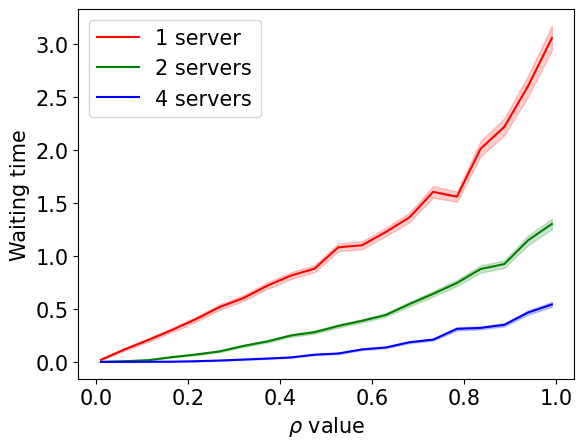

In [12]:
def rho_mean_ci(waiting_times_of_rhos,rhos_list, color, label, ls = 'solid'):
    means = []
    cis = []
    for waiting_times_run in waiting_times_of_rhos:
        mean, yerr = plot_conf_95(waiting_times_run)
        means.append(mean)
        cis.append(yerr)
    plt.plot(rhos_list, means, color = color, label = label, linestyle = ls)
    plt.fill_between(rhos_list, means - np.array(cis)[:, 0, 0], means + np.array(cis)[:, 0, 1], color = color, alpha = 0.2)
    print(f'{label} width of final CI: {cis[-1][0][0]+cis[-1][0][1]}')

rho_mean_ci(waiting_times_of_rhos_n1, rhos_list, 'red', '1 server')
rho_mean_ci(waiting_times_of_rhos_n2, rhos_list, 'green', '2 servers')
rho_mean_ci(waiting_times_of_rhos_n4, rhos_list, 'blue', '4 servers')
plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)
plt.legend(fontsize=15, loc = 2)
plt.tick_params(labelsize=15)
plt.show()

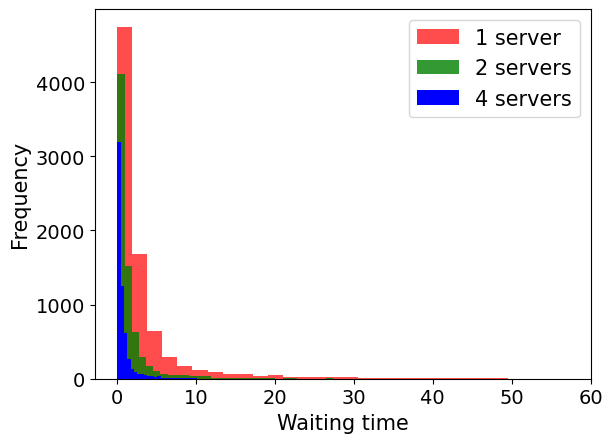

0.9384210526315789


In [6]:
waiting_times_given_notzero_n1 = waiting_times_of_rhos_n1[-2][waiting_times_of_rhos_n1[-2] !=0]
waiting_times_given_notzero_n2 = waiting_times_of_rhos_n2[-2][waiting_times_of_rhos_n2[-2] !=0]
waiting_times_given_notzero_n4 = waiting_times_of_rhos_n4[-2][waiting_times_of_rhos_n4[-2] !=0]

plt.hist(waiting_times_given_notzero_n1, bins=30, color = 'red', label = '1 server', alpha = 0.7)
plt.hist(waiting_times_given_notzero_n2, bins=30, color = 'green', label = '2 servers', alpha = 0.8)
plt.hist(waiting_times_given_notzero_n4, bins=30, color = 'blue', label = '4 servers')
plt.legend(fontsize = 15)
plt.tick_params(labelsize=14)
plt.xlabel('Waiting time', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.show()
print(rhos_list[-2])

Statistical analysis

In [15]:
# One-tailed Welch's test. all p-values can be divided by 2
def one_tailed_welchs_test(waiting_times_1, waiting_times_2):
    test = stat.ttest_ind(waiting_times_1,waiting_times_2, equal_var=False)
    statistic = test.statistic
    pvalue = test.pvalue
    df = test.df
    return statistic, pvalue/2, df # p/2 since we are performing a one-sided test

print("rho: ", rhos_list[0], "statistic, pvalue, df")
print(f'begin n = 1 with n = 2 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n1[0],waiting_times_of_rhos_n2[0])}')
print(f'begin n = 1 with n = 4 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n1[0],waiting_times_of_rhos_n4[0])}')
print(f'begin n = 2 with n = 4 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n2[0],waiting_times_of_rhos_n4[0])}')

print("rho: ", rhos_list[-1])
print(f'end n = 1 with n = 2 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n1[-1],waiting_times_of_rhos_n2[-1])}')
print(f'end n = 1 with n = 4 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n1[-1],waiting_times_of_rhos_n4[-1])}')
print(f'end n = 2 with n = 4 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n2[-1],waiting_times_of_rhos_n4[-1])}')

print(f"rho: {rhos_list[1]}")
print(f'begin n = 2 with n = 4 and {runs} runs: {one_tailed_welchs_test(waiting_times_of_rhos_n2[1],waiting_times_of_rhos_n4[1])}')

rho:  0.01 statistic, pvalue, df
begin n = 1 with n = 2 and 100 runs: (7.0261570340007955, 1.13032939158197e-12, 10054.270399731171)
begin n = 1 with n = 4 and 100 runs: (7.1070085740159445, 6.334234206128784e-13, 9999.0)
begin n = 2 with n = 4 and 100 runs: (1.353357343328412, 0.08798604580924456, 9999.0)
rho:  0.99
end n = 1 with n = 2 and 100 runs: (27.424430921658573, 1.62657412623769e-161, 13607.200443936517)
end n = 1 with n = 4 and 100 runs: (41.92744176281814, 0.0, 10861.814293911128)
end n = 2 with n = 4 and 100 runs: (27.003355145260723, 5.2519081048498363e-157, 14393.078997735569)
rho: 0.06157894736842105
begin n = 2 with n = 4 and 100 runs: (5.830424021433578, 2.849285394956843e-09, 10077.10444784823)


In [114]:
# Paired sample t-test

print(f"n = 1 and {runs} runs: {stat.ttest_rel(waiting_times_of_rhos_n1[0], waiting_times_of_rhos_n1[-1])}")
print(f"n = 2 and {runs} runs: {stat.ttest_rel(waiting_times_of_rhos_n2[0], waiting_times_of_rhos_n2[-1])}")
print(f"n = 4 and {runs} runs: {stat.ttest_rel(waiting_times_of_rhos_n4[0], waiting_times_of_rhos_n4[-1])}")

n = 1 and 200 runs: TtestResult(statistic=-51.63332965312102, pvalue=0.0, df=9999)
n = 2 and 200 runs: TtestResult(statistic=-51.32487952121593, pvalue=0.0, df=9999)
n = 4 and 200 runs: TtestResult(statistic=-44.40611993344844, pvalue=0.0, df=9999)


**3D plot for rho and number of runs**

In [16]:
def ci_runs_rhos(rhos_list, runs_list, servers):
    ci_width_matrix = np.zeros(shape = (len(runs_list),len(rhos_list)))
    for run_index, runs in enumerate(runs_list):
        print('run',runs)
        wait_times_per_rho = waiting_times_of_rhos(rhos_list, servers, runs)
        for rho_index, waiting_times_of_rho in enumerate(wait_times_per_rho):
            _, yerr = plot_conf_95(waiting_times_of_rho)
            width_ci = yerr[0][1]-yerr[0][0]
            ci_width_matrix[run_index, rho_index] = width_ci
    return ci_width_matrix

rhos_list = np.linspace(0.2,0.99,17)
runs_list = range(10,1001,30)
random.seed(3)

ci_width = ci_runs_rhos(rhos_list, runs_list, 2)

run 10
run 40
run 70
run 100
run 130
run 160
run 190
run 220
run 250
run 280
run 310
run 340
run 370
run 400
run 430
run 460
run 490
run 520
run 550
run 580
run 610
run 640
run 670
run 700
run 730
run 760
run 790
run 820
run 850
run 880
run 910
run 940
run 970
run 1000


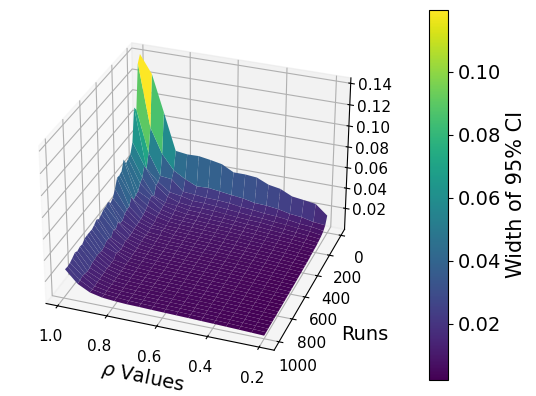

In [176]:
from mpl_toolkits.mplot3d import Axes3D

grid = np.meshgrid(rhos_list, runs_list)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(grid[0], grid[1], ci_width, cmap='viridis')

ax.set_xlabel('$\\rho$ Values', fontsize = 14)
ax.set_ylabel('Runs', fontsize = 14, labelpad=13)
# ax.set_zlabel('Standard Deviation')

ax.view_init(azim = 110)

colorbar = fig.colorbar(surface, ax=ax, pad=0.1)
colorbar.set_label('Width of 95% CI', size=15)
colorbar.ax.tick_params(labelsize=14)

ax.tick_params(labelsize=11)

plt.show()


**Question 3: compare FIFO and SJF**

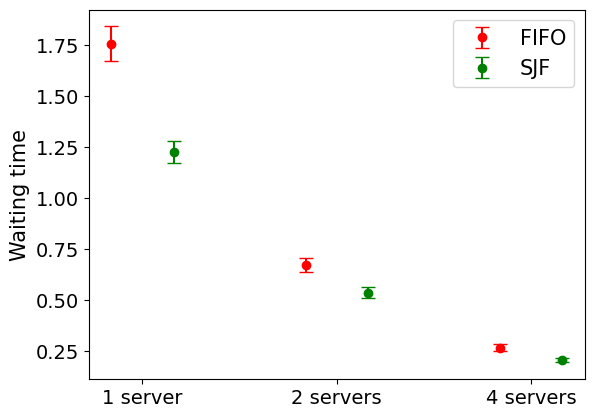

In [10]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='FIFO', color = 'red')
plt.errorbar(x=1+0.16, y=m1_sjf, yerr=yerr1_sjf.T, fmt='o', capsize=5, label='SJF', color = 'green')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2+0.16, y=m2_sjf, yerr=yerr2_sjf.T, fmt='o', capsize=5,color = 'green')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3+0.16, y=m4_sjf, yerr=yerr4_sjf.T, fmt='o', capsize=5,color = 'green')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'], fontsize = 15)
plt.ylabel('Waiting time', fontsize = 15)
plt.tick_params(labelsize = 14)
plt.legend(fontsize = 15)
plt.show()

In [19]:
# compare average waiting time between FIFO and SJF
random.seed(3)
runs = 200
n_customers = 50
mu = 1/2

env = simpy.Environment()
rhos_list = np.linspace(0.01,0.99,20)

waiting_times_of_rhos_n1_sjf = waiting_times_of_rhos(rhos_list, 1, runs, 'SJF')
waiting_times_of_rhos_n2_sjf = waiting_times_of_rhos(rhos_list, 2, runs, 'SJF')
waiting_times_of_rhos_n4_sjf = waiting_times_of_rhos(rhos_list, 4, runs, 'SJF')

_FIFO (n = 1) width of final CI: 0.2298953515386346
_SJF (n = 1) width of final CI: 0.11618221393210515
_FIFO (n = 2) width of final CI: 0.09933992568782868
_SJF (n = 2) width of final CI: 0.04922407299205278
_FIFO (n = 4) width of final CI: 0.04779703151543746
_SJF (n = 4) width of final CI: 0.02421464727201783


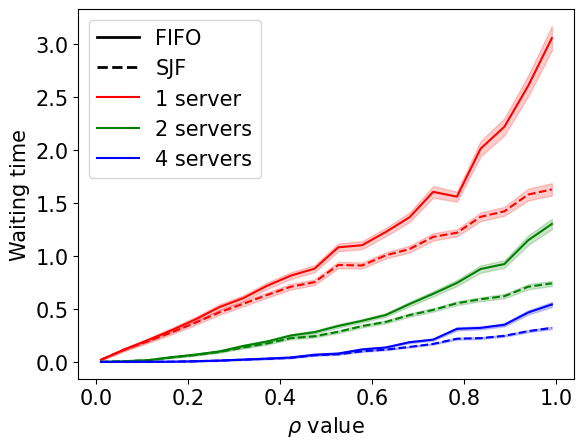

In [12]:
from matplotlib.lines import Line2D

rho_mean_ci(waiting_times_of_rhos_n1, rhos_list, 'red', '_FIFO (n = 1)')
rho_mean_ci(waiting_times_of_rhos_n1_sjf, rhos_list, 'red', '_SJF (n = 1)', '--')

rho_mean_ci(waiting_times_of_rhos_n2, rhos_list, 'green', '_FIFO (n = 2)')
rho_mean_ci(waiting_times_of_rhos_n2_sjf, rhos_list, 'green', '_SJF (n = 2)', '--')

rho_mean_ci(waiting_times_of_rhos_n4, rhos_list, 'blue', '_FIFO (n = 4)')
rho_mean_ci(waiting_times_of_rhos_n4_sjf, rhos_list, 'blue', '_SJF (n = 4)', '--')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

custom_lines = [
    Line2D([0],[0], color='black', linestyle='-', lw=2),
    Line2D([0],[0], color='black', linestyle='--', lw=2),
    Line2D([0],[0], color = 'red'),
    Line2D([0],[0], color = 'green'),
    Line2D([0],[0], color = 'blue'),
]

legend_labels = ['FIFO', 'SJF', '1 server', '2 servers', '4 servers']
plt.legend(custom_lines, legend_labels, loc='best', fontsize = 15)
# legend = ['FIFO', None, 'SJF', '1 server', '2 servers', '4 servers']
# plt.legend(legend)
# plt.legend(fontsize=15, loc = 2)
plt.tick_params(labelsize=15)
plt.show()

In [13]:
print(f"For a queue with in total {n_customers} people that get in the queue with system load {rho} for {runs} days:")
print(f"the mean waiting time was {m1}, with a standard deviation of {yerr1}")
print(f"the mean waiting time was {m2}, with a standard deviation of {yerr2}")
print(f"the mean waiting time was {m4}, with a standard deviation of {yerr4}")

print(f"the mean waiting time sjf was {m1_sjf}, with a standard deviation of {yerr1_sjf}")
print(f"the mean waiting time sjf was {m2_sjf}, with a standard deviation of {yerr2_sjf}")
print(f"the mean waiting time sjf was {m4_sjf}, with a standard deviation of {yerr4_sjf}")


For a queue with in total 50 people that get in the queue with system load 0.8 for 200 days:
the mean waiting time was 1.7569604784551172, with a standard deviation of [[0.08426136 0.08426136]]
the mean waiting time was 0.6733589538804021, with a standard deviation of [[0.03341835 0.03341835]]
the mean waiting time was 0.2671974348063016, with a standard deviation of [[0.01753896 0.01753896]]
the mean waiting time sjf was 1.225658929560469, with a standard deviation of [[0.05335058 0.05335058]]
the mean waiting time sjf was 0.5370568509711487, with a standard deviation of [[0.02538077 0.02538077]]
the mean waiting time sjf was 0.2059172554762349, with a standard deviation of [[0.01161692 0.01161692]]


**Check overlap van confidence intervals**

In [74]:
def check_overlap_ci(rho_index, waiting_times_of_rhos, waiting_times_of_rhos_sjf):
    print(rho_index)
    print(rhos_list[rho_index])
    # means - np.array(cis)[:, 0, 0]

    # FIFO: lower bound
    mean_fifo, yerr_fifo = plot_conf_95(waiting_times_of_rhos[rho_index])
    
    # SJF: upper bound
    mean_sjf, yerr_sjf = plot_conf_95(waiting_times_of_rhos_sjf[rho_index])
    
    # 
    lower_fifo = mean_fifo - np.array(yerr_fifo)[0, 0]
    upper_sjf = mean_sjf + np.array(yerr_sjf)[0, 1]
    if lower_fifo < upper_sjf:
        print('overlap')
    else:
        print('no overlap')

print("1 server")
for i in range(5,7):
    check_overlap_ci(i, waiting_times_of_rhos_n1, waiting_times_of_rhos_n1_sjf)

print("\n2 servers")
for i in range(7,9):
    check_overlap_ci(i, waiting_times_of_rhos_n2, waiting_times_of_rhos_n2_sjf)

print("\n4 servers")
for i in range(10,12):
    check_overlap_ci(i, waiting_times_of_rhos_n4, waiting_times_of_rhos_n4_sjf)

1 server
5
0.26789473684210524
overlap
6
0.3194736842105263
no overlap

2 servers
7
0.37105263157894736
overlap
8
0.4226315789473684
no overlap

4 servers
10
0.5257894736842105
overlap
11
0.5773684210526315
no overlap


In [26]:
# Wilcoxon signed rank test to test difference for n = 1 with low rho and high rho
# print(rhos_list)

def overlap_welch_test(i, fifo, sjf,n):
    print(f"normality FIFO: {stat.shapiro(fifo)}")
    print(f"normality SJF: {stat.shapiro(sjf)}")
    print(f"one-tailed welch n = {n} ({runs} runs) rho {rhos_list[i]}: {one_tailed_welchs_test(fifo, sjf)}")

i_n1=6
fifo_n1 = waiting_times_of_rhos_n1[i_n1]
sjf_n1 = waiting_times_of_rhos_n1_sjf[i_n1]

i_n2=8
fifo_n2 = waiting_times_of_rhos_n2[i_n2]
sjf_n2 = waiting_times_of_rhos_n2_sjf[i_n2]

i_n4=11
fifo_n4 = waiting_times_of_rhos_n4[i_n4]
sjf_n4 = waiting_times_of_rhos_n4_sjf[i_n4]

overlap_welch_test(i_n1, fifo_n1, sjf_n1,1)
print('\n')
overlap_welch_test(i_n2, fifo_n2, sjf_n2,2)
print('\n')
overlap_welch_test(i_n4, fifo_n4, sjf_n4,4)



normality FIFO: ShapiroResult(statistic=0.5062721967697144, pvalue=0.0)
normality SJF: ShapiroResult(statistic=0.5173633694648743, pvalue=0.0)
one-tailed welch n = 1 (200 runs) rho 0.3194736842105263: (2.865082359373402, 0.0020867037486027766, 19743.663619676827)


normality FIFO: ShapiroResult(statistic=0.4534953832626343, pvalue=0.0)
normality SJF: ShapiroResult(statistic=0.4661226272583008, pvalue=0.0)
one-tailed welch n = 2 (200 runs) rho 0.4226315789473684: (2.9300622772721825, 0.0016964182609201176, 19662.161548522257)


normality FIFO: ShapiroResult(statistic=0.3840405344963074, pvalue=0.0)
normality SJF: ShapiroResult(statistic=0.4143882393836975, pvalue=0.0)
one-tailed welch n = 4 (200 runs) rho 0.5773684210526315: (4.030783777590551, 2.7903670421776475e-05, 19043.547155751614)


**Opdracht 4**

In [115]:
random.seed(3)
runs = 200
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1_Det = []
wait_total_n2_Det = []
wait_total_n4_Det = []

wait_total_n1_Hexp = []
wait_total_n2_Hexp = []
wait_total_n4_Hexp = []


for i in range(runs):
    MD1queue_fifo = Queue(env,1,rho,mu, service_distribution="D")
    MD2queue_fifo = Queue(env,2,rho,mu, service_distribution="D")
    MD4queue_fifo = Queue(env,4,rho,mu, service_distribution="D")
    
    wait_total_n1_Det.extend(MD1queue_fifo.run_sim(n_customers))
    wait_total_n2_Det.extend(MD2queue_fifo.run_sim(n_customers))
    wait_total_n4_Det.extend(MD4queue_fifo.run_sim(n_customers))

    MH1queue_fifo = Queue(env,1,rho,mu, service_distribution="H")
    MH2queue_fifo = Queue(env,2,rho,mu, service_distribution="H")
    MH4queue_fifo = Queue(env,4,rho,mu, service_distribution="H")
    
    wait_total_n1_Hexp.extend(MH1queue_fifo.run_sim(n_customers))
    wait_total_n2_Hexp.extend(MH2queue_fifo.run_sim(n_customers))
    wait_total_n4_Hexp.extend(MH4queue_fifo.run_sim(n_customers))


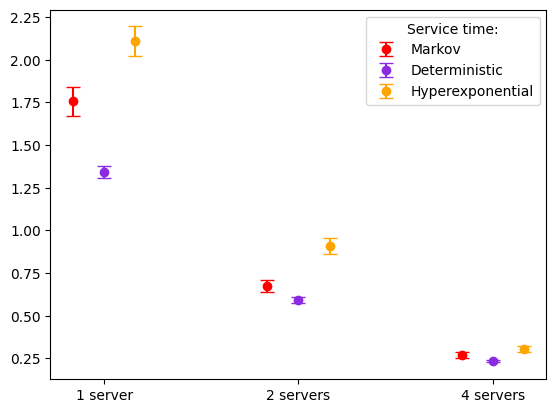

In [116]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

m1_Det, yerr1_Det = plot_conf_95(wait_total_n1_Det)
m2_Det, yerr2_Det = plot_conf_95(wait_total_n2_Det)
m4_Det, yerr4_Det = plot_conf_95(wait_total_n4_Det)

m1_Hexp, yerr1_Hexp = plot_conf_95(wait_total_n1_Hexp)
m2_Hexp, yerr2_Hexp = plot_conf_95(wait_total_n2_Hexp)
m4_Hexp, yerr4_Hexp = plot_conf_95(wait_total_n4_Hexp)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='Markov', color = 'red')
plt.errorbar(x=1, y=m1_Det, yerr=yerr1_Det.T, fmt='o', capsize=5, label='Deterministic', color = 'blueviolet')
plt.errorbar(x=1+0.16, y=m1_Hexp, yerr=yerr1_Hexp.T, fmt='o', capsize=5, label='Hyperexponential', color = 'orange')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2, y=m2_Det, yerr=yerr2_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=2+0.16, y=m2_Hexp, yerr=yerr2_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3, y=m4_Det, yerr=yerr4_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=3+0.16, y=m4_Hexp, yerr=yerr4_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'])
plt.legend(title="Service time:")
plt.show()

In [117]:
# compare average waiting time between FIFO and SJF
random.seed(3)
runs = 200
n_customers = 50
mu = 1/2

env = simpy.Environment()
rhos_list = np.linspace(0.01,0.99,20)

waiting_times_of_rhos_n1_det = waiting_times_of_rhos(rhos_list, 1, runs, service_distribution='D')
waiting_times_of_rhos_n2_det = waiting_times_of_rhos(rhos_list, 2, runs, service_distribution='D')
waiting_times_of_rhos_n4_det = waiting_times_of_rhos(rhos_list, 4, runs, service_distribution='D')

waiting_times_of_rhos_n1_hyp = waiting_times_of_rhos(rhos_list, 1, runs, service_distribution='H')
waiting_times_of_rhos_n2_hyp = waiting_times_of_rhos(rhos_list, 2, runs, service_distribution='H')
waiting_times_of_rhos_n4_hyp = waiting_times_of_rhos(rhos_list, 4, runs, service_distribution='H')

_Markov (n = 1) width of final CI: 0.2298953515386346
_Deter (n = 1) width of final CI: 0.12778414071743782
_Hyper (n = 1) width of final CI: 0.3497796459224869
_Markov (n = 2) width of final CI: 0.09933992568782868
_Deter (n = 2) width of final CI: 0.05494416484195197
_Hyper (n = 2) width of final CI: 0.14339288672526385
_Markov (n = 4) width of final CI: 0.04779703151543746
_Deter (n = 4) width of final CI: 0.03184352112608735
_Hyper (n = 4) width of final CI: 0.06629290171293456


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


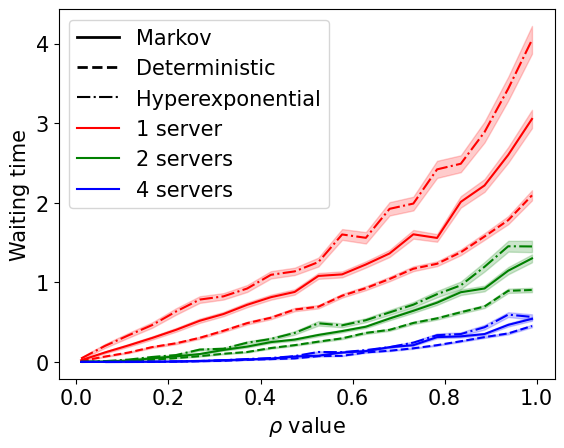

In [118]:
rho_mean_ci(waiting_times_of_rhos_n1, rhos_list, 'red', '_Markov (n = 1)')
rho_mean_ci(waiting_times_of_rhos_n1_det, rhos_list, 'red', '_Deter (n = 1)', '--')
rho_mean_ci(waiting_times_of_rhos_n1_hyp, rhos_list, 'red', '_Hyper (n = 1)', '-.')

rho_mean_ci(waiting_times_of_rhos_n2, rhos_list, 'green', '_Markov (n = 2)')
rho_mean_ci(waiting_times_of_rhos_n2_det, rhos_list, 'green', '_Deter (n = 2)', '--')
rho_mean_ci(waiting_times_of_rhos_n2_hyp, rhos_list, 'green', '_Hyper (n = 2)', '-.')

rho_mean_ci(waiting_times_of_rhos_n4, rhos_list, 'blue', '_Markov (n = 4)')
rho_mean_ci(waiting_times_of_rhos_n4_det, rhos_list, 'blue', '_Deter (n = 4)', '--')
rho_mean_ci(waiting_times_of_rhos_n4_hyp, rhos_list, 'blue', '_Hyper (n = 4)', '-.')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

custom_lines = [
    Line2D([0], [0], color='black', linestyle='-', lw=2),
    Line2D([0], [0], color='black', linestyle='--', lw=2),
    Line2D([0],[0], color = 'black', linestyle = '-.'),
    Line2D([0],[0], color = 'red'),
    Line2D([0],[0], color = 'green'),
    Line2D([0],[0], color = 'blue'),
]

legend_labels = ['Markov', 'Deterministic', 'Hyperexponential', '1 server', '2 servers', '4 servers']
plt.legend(custom_lines, legend_labels, loc='best', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

Markov width of final CI: 0.2298953515386346
Deterministic width of final CI: 0.12778414071743782
Hyperexponential width of final CI: 0.3497796459224869


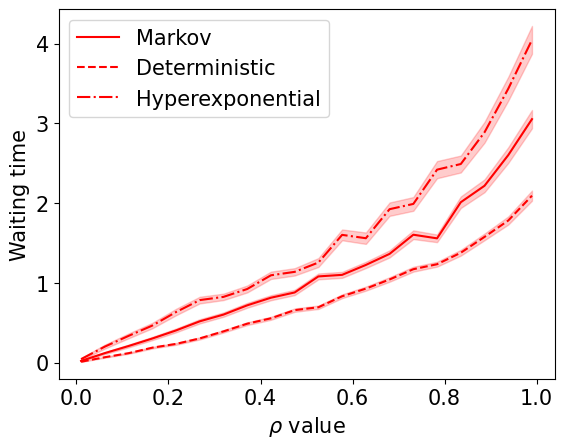

Markov width of final CI: 0.09933992568782868
Deterministic width of final CI: 0.05494416484195197
Hyperexponential width of final CI: 0.14339288672526385


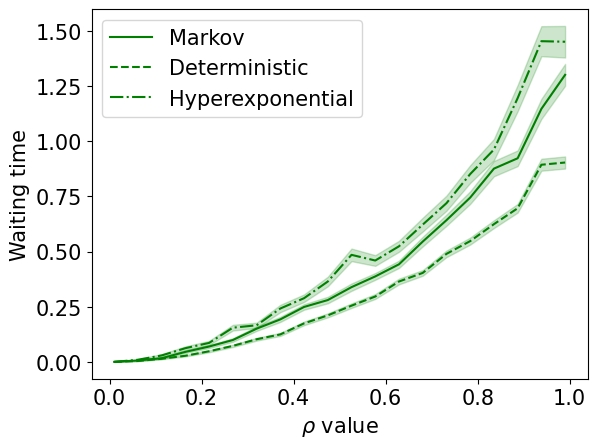

Markov width of final CI: 0.04779703151543746
Deterministic width of final CI: 0.03184352112608735
Hyperexponential width of final CI: 0.06629290171293456


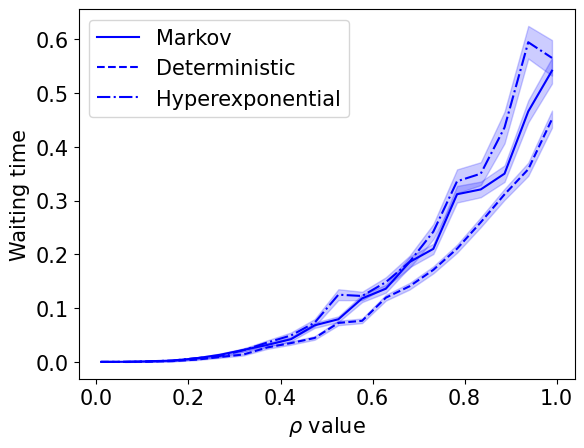

In [119]:
rho_mean_ci(waiting_times_of_rhos_n1, rhos_list, 'red', 'Markov')
rho_mean_ci(waiting_times_of_rhos_n1_det, rhos_list, 'red', 'Deterministic', '--')
rho_mean_ci(waiting_times_of_rhos_n1_hyp, rhos_list, 'red', 'Hyperexponential', '-.')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

plt.legend(fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

rho_mean_ci(waiting_times_of_rhos_n2, rhos_list, 'green', 'Markov')
rho_mean_ci(waiting_times_of_rhos_n2_det, rhos_list, 'green', 'Deterministic', '--')
rho_mean_ci(waiting_times_of_rhos_n2_hyp, rhos_list, 'green', 'Hyperexponential', '-.')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

plt.legend(fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

rho_mean_ci(waiting_times_of_rhos_n4, rhos_list, 'blue', 'Markov')
rho_mean_ci(waiting_times_of_rhos_n4_det, rhos_list, 'blue', 'Deterministic', '--')
rho_mean_ci(waiting_times_of_rhos_n4_hyp, rhos_list, 'blue', 'Hyperexponential', '-.')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

plt.legend(fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

In [153]:
# more runs for n = 4 (to test if there might be a significant difference there)
runs = 1000
random.seed(3)

waiting_times_of_rhos_n4_300 = waiting_times_of_rhos(rhos_list, 4, runs, service_distribution='M')
waiting_times_of_rhos_n4_300det = waiting_times_of_rhos(rhos_list, 4, runs, service_distribution='D')
waiting_times_of_rhos_n4_300hyp = waiting_times_of_rhos(rhos_list, 4, runs, service_distribution='H')

Markov width of final CI: 0.01989613523646372
Deterministic width of final CI: 0.013249116667471639
Hyperexponential width of final CI: 0.027824755230250853


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


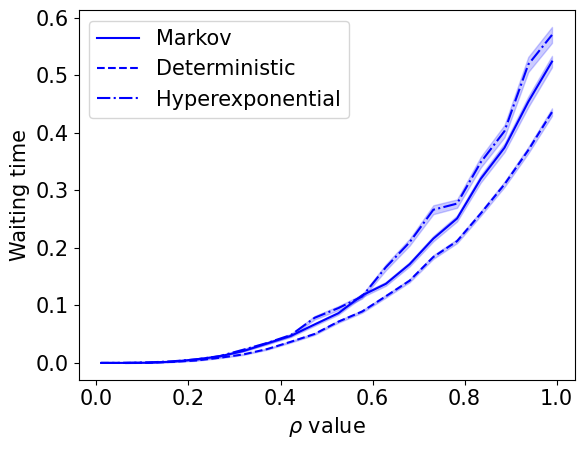

In [154]:
rho_mean_ci(waiting_times_of_rhos_n4_300, rhos_list, 'blue', 'Markov')
rho_mean_ci(waiting_times_of_rhos_n4_300det, rhos_list, 'blue', 'Deterministic', '--')
rho_mean_ci(waiting_times_of_rhos_n4_300hyp, rhos_list, 'blue', 'Hyperexponential', '-.')

plt.xlabel('$\\rho$ value', fontsize=15)
plt.ylabel('Waiting time', fontsize=15)

plt.legend(fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

**check overlap**

In [156]:
print(rhos_list)

print("\nM vs D - 1 server")
check_overlap_ci(1, waiting_times_of_rhos_n1, waiting_times_of_rhos_n1_det)
print("\nM vs D - 2 server")
check_overlap_ci(3, waiting_times_of_rhos_n2, waiting_times_of_rhos_n2_det)
print("\nM vs D - 4 server")
check_overlap_ci(4, waiting_times_of_rhos_n4, waiting_times_of_rhos_n4_det)

print("\nM vs H - 1 server")
check_overlap_ci(1, waiting_times_of_rhos_n1_hyp, waiting_times_of_rhos_n1)
print("\nM vs H - 2 server")
check_overlap_ci(2, waiting_times_of_rhos_n2_hyp, waiting_times_of_rhos_n2)
print("\nM vs H - 4 server")
check_overlap_ci(4, waiting_times_of_rhos_n4, waiting_times_of_rhos_n4_det)

print("for loop")
for i in range(1,len(rhos_list)):
    check_overlap_ci(i, waiting_times_of_rhos_n4_hyp, waiting_times_of_rhos_n4)


[0.01       0.06157895 0.11315789 0.16473684 0.21631579 0.26789474
 0.31947368 0.37105263 0.42263158 0.47421053 0.52578947 0.57736842
 0.62894737 0.68052632 0.73210526 0.78368421 0.83526316 0.88684211
 0.93842105 0.99      ]

M vs D - 1 server
1
0.06157894736842105
no overlap

M vs D - 2 server
3
0.16473684210526315
no overlap

M vs D - 4 server
4
0.2163157894736842
no overlap

M vs H - 1 server
1
0.06157894736842105
no overlap

M vs H - 2 server
2
0.1131578947368421
no overlap

M vs H - 4 server
4
0.2163157894736842
no overlap
for loop
1
0.06157894736842105
overlap
2
0.1131578947368421
overlap
3
0.16473684210526315
overlap
4
0.2163157894736842
overlap
5
0.26789473684210524
overlap
6
0.3194736842105263
overlap
7
0.37105263157894736
overlap
8
0.4226315789473684
overlap
9
0.47421052631578947
overlap
10
0.5257894736842105
no overlap
11
0.5773684210526315
overlap
12
0.6289473684210526
overlap
13
0.6805263157894736
overlap
14
0.7321052631578947
no overlap
15
0.7836842105263158
overlap
16
0.